In [95]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
from iminuit import Minuit

## Analysis of probability distribution

In this report, we will be analysing a decay process X -> D which can be caractarised by the folowing probaboility distribution:
\begin{equation}
P(t;\tau, \Delta m_s, V) \;\; \alpha \;\; (1 + Vsin(\Delta mt)) \cdot e^{-t/\tau}
\end{equation}

We note that the above equation is only proportionate and is unormalised. In order to make the above equation a PDF we would need to add a normalisation factior, $t_{norm}$.

In this section of the report, we will create a lambda function to analise the functional form of the drobability distribution in order to help us later on in the analysis.

We are told to look at this distribution within the bounds of $t \in [0, 10]$

In [96]:
# Lambda function of pdf
distribution = lambda t, tau, delta_mass, V : (1 + V*np.sin(delta_mass*t))*np.exp(-t/tau)

# We define function bounds and time values
X_BOUNDS = (0, 10)

# Define the time values
n_steps = 100                           # For now we will plot 100 points within the bounds
t = np.linspace(*X_BOUNDS, n_steps, endpoint=True)


We now pick different sets of parameters ot investigate how they afect the functional form of the distribution. From looking at the equation, we can expect the function to take a decaying sinusoidal form with $\tau$ being the decay constant, V be the amplitude of the harmonic component and $\Delta m_s$ to be the angular frequency of the harmonic

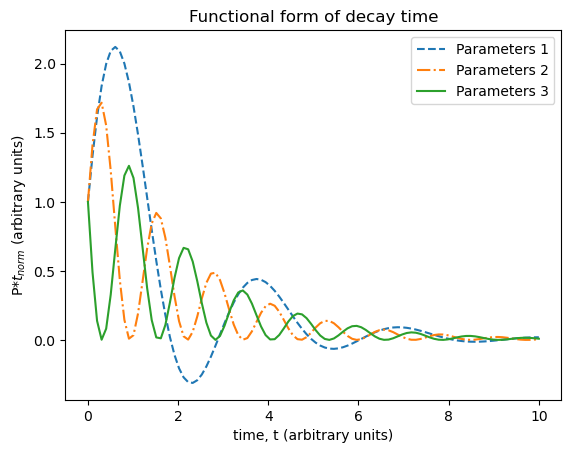

In [97]:
# Choosing different parameters (tau, delta_mass, Potential)
parameters_1 = (2.0, 2.0, 2.0)
parameters_2 = (2.0, 5.0, 1.0)
parameters_3 = (2.0, 5.0, -1.0)

# We plot the function for these parameters
plt.plot(t, distribution(t, *parameters_1), label="Parameters 1", ls="--")
plt.plot(t, distribution(t, *parameters_2), label="Parameters 2", ls="-.")
plt.plot(t, distribution(t, *parameters_3), label="Parameters 3", ls="-")
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Functional form of decay time")
plt.legend()

We will need to create an algorithm to randomly draw a value within this distribution. There are multiple methods for us to do so.

Let us try to use the box method for a start. We note that in this case as the minimum value of the distribution is not zero, We will need to identify the max and min point of the distriution in order for us to define the box around the distribution.

We will test our function by trying to find the maximum and minimum point of the function using parameters_1, which from the plot we expect a y_max of ~ 2.1 and y_min of ~ -0.3.5

In [98]:
# Function to find max point of the distribution
def find_max(function, bound_low, bound_high, grid=100000,):
    """
    Return the maximum value of a function
    """
    # Note that grid defines the number of steps within thedefined range
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    # Compute and return the maximum point of function
    y = function(x, *parameters_1)
    return y.max()

# Function to find min point of the distribution
def find_min(function, bound_low, bound_high, grid=100000,):
    """
    Return the minimum value of a function
    """
    # Note that grid defines the number of steps within thedefined range
    if (not grid >= 0):
        raise ValueError("Grid must be a a positive intiger")
    # Generate grid of x values
    x = np.linspace(bound_low, bound_high, num=grid, endpoint=True,)
    # Compute and return the minimum point of function
    y = function(x, *parameters_1)
    return y.min()

y_max = find_max(distribution, *X_BOUNDS)
y_min = find_min(distribution, *X_BOUNDS)
Y_BOUNDS = (y_min, y_max)
print(f"Maximum point of distribution with parameters_1 is {y_max:.3f}")
print(f"Minimum point of distribution with parameters_1 is {y_min:.3f}")

Maximum point of distribution with parameters_1 is 2.122
Minimum point of distribution with parameters_1 is -0.313


Now that we have obtained the maximum and minimum points, we will attempt to implement an algoritm to randomly draw values within this distribution using the box method.

In [99]:
def box_method(func, x_min, x_max, y_min, y_max):
    while True:
        x = np.random.uniform(x_min, x_max)
        y_function = func(x, *parameters_1)
        y_box = np.random.uniform(y_min, y_max)
        if y_box <= y_function:
            return (x, y_box)

We now generate 5000 random points and check they are within the bounds of the distribution

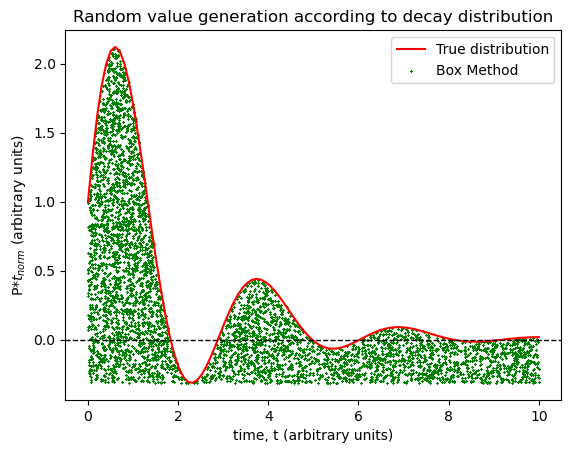

In [100]:
random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = box_method(distribution, *X_BOUNDS, *Y_BOUNDS)
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, distribution(t, *parameters_1), label="True distribution", c="red")
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Box Method")
plt.axhline(0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="--", c="black", linewidth=1)
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()


We notice that we are getting random points being drawn below the function line. But this is not what is required. We require the random points to be drawn from the area bounded between the function line and the x axis. As a result, to fix this, we must discriminate random points where $y_{func}$ is above and below the x axis. Fow points where $y_{func}$ is negative, we accept $y_{box}$ if it is greater than $y_{func}$.

We write the fixed function below and re-generate 5000 random points ot see if it is working:

In [101]:
def box_method_fixed(func, x_min, x_max, y_min, y_max):
    while True:
        x = np.random.uniform(x_min, x_max)
        y_function = func(x, *parameters_1)
        y_box = np.random.uniform(y_min, y_max)
        # Accept condition if y_function is above x axis
        if (y_function >= 0.0) and (y_box>= 0.0) and (y_box <= y_function):
            return (x, y_box)
        # Accept condition if y_function is below x axis
        if (y_function <= 0.0) and (y_box <= 0) and (y_box >= y_function):
            return (x, y_box)

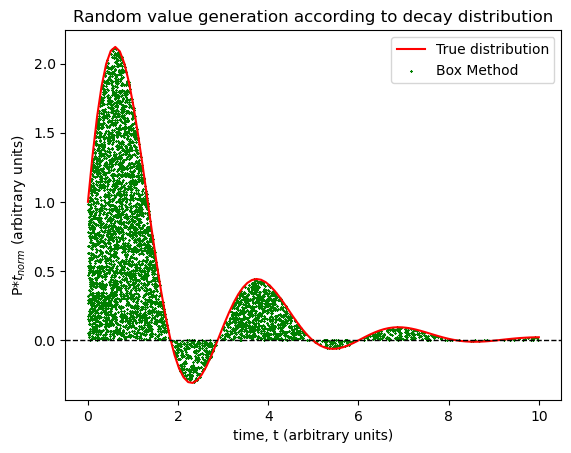

In [102]:
random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = box_method_fixed(distribution, *X_BOUNDS, *Y_BOUNDS)
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, distribution(t, *parameters_1), label="True distribution", c="red")
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Box Method")
plt.axhline(0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="--", c="black", linewidth=1)
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()

We can now create a class called HarmonicWithDecay which contain methods to generate random points in a distribution of this form and set different parameters

In [103]:

class HarmonicWithDecay(object):
    """
    Class that will generate a random value according to a harminic signal with exponential decay
    """

    def __init__(self, tau, deltaMass, V, bounds):

        if (not isinstance(bounds, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (boundMin, boundMax)")
        if (not len(bounds) == 2):
            raise ValueError("Variable bound must have form (boundMin, boundMax)")
        if (not bounds[0] < bounds[1]):
            raise ValueError("First element in tuple must be smaller than second")

        # Initialise class variables
        self.boundMin, self.boundMax = bounds
        self.tau = tau
        self.deltaMass = deltaMass
        self.V = V 

        # Initialise array to contain generated events
        self.mass = []

        # Find maximum and minimum values of the distribution within the bounds
        self.maxValue = self._findMax()
        self.minValue = self._findMin()

    def evaluate(self, t,):
        """
        Evaluate the function of the distribution
        NOTE: Returns un-normalised values
        """
        
        return (1 + self.V*np.sin(self.deltaMass*t))*np.exp(-t/self.tau)

    def next(self,):
        """
        Generate a single random variable according to the class' distribution using the box method.
        Will return and append generated variable to mass list.
        """

        while True:
            x = np.random.uniform(self.boundMin, self.boundMax)
            y_function = self.evaluate(x,)
            y_box = np.random.uniform(self.minValue, self.maxValue)
            # Accept condition if y_function is above x axis
            if (y_function >= 0.0) and (y_box>= 0.0) and (y_box <= y_function):
                self.mass.append(y_box)
                return (x, y_box)
            # Accept condition if y_function is below x axis
            if (y_function <= 0.0) and (y_box <= 0) and (y_box >= y_function):
                self.mass.append(y_box)
                return (x, y_box)
        
    def setParameters(self, tau=None, deltaMass=None, V=None):
        """
        Set passed variables as parameters for pdf
        """

        # Use default values for parameters of none are passed through kwargs
        if not tau == None:                     self.tau = tau
        if not deltaMass == None:               self.deltaMass = deltaMass       
        if not V == None:                       self.V = V     

    def integrate(self, limits):
        """
        Evaluate the integral of the pdf within the specified bounds
        ##### NOTE: Integral is not normalised within the specified bounds of the class #####
        """

        if (not isinstance(limits, tuple)):
            raise TypeError("Variable bound must be a tuple with the form (limitMin, limitMax)")
        if (not len(limits) == 2):
            raise ValueError("Variable bound must have form (limitMin, limitMax)")
        if (not limits[0] < limits[1]):
            raise ValueError("First element in tuple must be smaller than second")
        if (not limits[0] >= self.boundMin):
            raise ValueError("Lower integral limit must be larger than lower bound of pdf")
        if (not limits[1] <= self.boundMax):
            raise ValueError("Higher integral limit must be smaller than upper bound of pdf")
    
        limitLow, limitHigh = limits
        integralResult, IntegralError = quad(self.evaluate, limitLow, limitHigh) 
        return integralResult

    def _findMax(self, grid=100000,):
        """
        Return the maximum value of a function
        """
        # Note that grid defines the number of steps within thedefined range
        if (not grid >= 0):
            raise ValueError("Grid must be a a positive intiger")
        # Generate grid of x values
        x = np.linspace(self.boundMin, self.boundMax, num=grid, endpoint=True,)
        # Compute and return the maximum point of function
        y = self.evaluate(x)
        return y.max()

    def _findMin(self,grid=100000,):
        """
        Return the minimum value of a function
        """
        # Note that grid defines the number of steps within thedefined range
        if (not grid >= 0):
            raise ValueError("Grid must be a a positive intiger")
        # Generate grid of x values
        x = np.linspace(self.boundMin, self.boundMax, num=grid, endpoint=True,)
        # Compute and return the minimum point of function
        y = self.evaluate(x)
        return y.min()
    
    def getMass(self,):
        """
        Return numpy array containing all generated values
        """

        return np.array(self.mass)

We will test the class by trying to recreate the plot using a new set of parameters

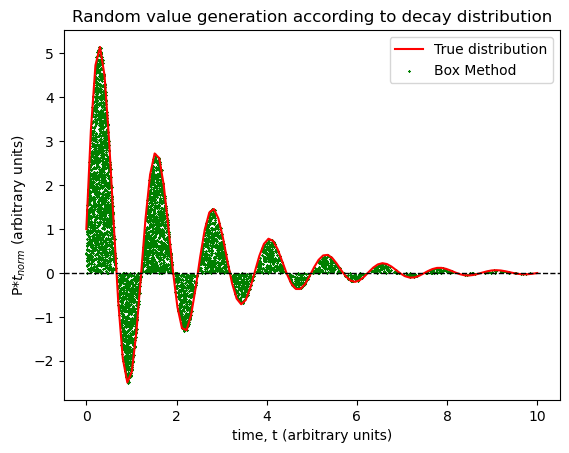

In [104]:
pdf = HarmonicWithDecay(tau=2.0, deltaMass=5.0, V=5.0, bounds=X_BOUNDS)

random_points_x = []
random_points_y = []
n_random_points = 5000

# Generate 5000 points
for _ in range(n_random_points):
    x, y = pdf.next()
    random_points_x.append(x)
    random_points_y.append(y)

# Plot function and points
plt.plot(t, pdf.evaluate(t,), label="True distribution", c="red")
plt.scatter(random_points_x, random_points_y, s=0.7, marker="x", c="g", label="Box Method")
plt.axhline(0, xmin=X_BOUNDS[0], xmax=X_BOUNDS[1], linestyle="--", c="black", linewidth=1)
plt.xlabel("time, t (arbitrary units)")
plt.ylabel(r"P*$t_{norm}$ (arbitrary units)")
plt.title("Random value generation according to decay distribution")
plt.legend()

As we can see from the plot, We have succesfully created a class which can generate points from the decay distribution.